# Idea
The idea is that we predict rotated linear dimension position from lines and text from the drawing.

# Thoughts
Basic logic is we split dataset to input lines or texts positions StartPoint, EndPoint, Position XYZ and predict dimension extension line poistion XLine1Point, XLine2Point XYZ.

We going to group samples by FileId. That is each sample will contain variable length data (attributes of variable number of  lines and text) and variable output data (variable number of dimensions).

I intend to [use RNN for it](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
import torch
from torch import nn
from torch.utils.data import Dataset, SubsetRandomSampler
from torch.nn import functional as F

device = torch.device("cpu")
# if torch.cuda.is_available():
#    device = torch.device("cuda")
    
device

device(type='cpu')

# Dataset implementation

In [3]:
from dataset import DwgDataset
batch_size = 2

dwg_dataset = DwgDataset(pickle_file = 'test_dataset.pickle', batch_size = batch_size)

train_loader = dwg_dataset.train_loader
val_loader   = dwg_dataset.val_loader
test_loader  = dwg_dataset.test_loader

ent_features = dwg_dataset.entities.ent_features
dim_features = dwg_dataset.entities.dim_features

In [4]:
for c,d in dwg_dataset.entities:
    # print(c.shape, d.shape)
    # make sure we have every training sample not empty
    assert( c.shape[0] != 0)    

In [5]:
(a,b) = next(iter(train_loader))
print(len(a),len(b))
for (x,y) in iter(train_loader):
    for xx in x:
        print(xx.shape)
        pass
    for yy in y:
        print(yy.shape)
    # print(a.shape,b.shape)
    break

2 2
torch.Size([603, 9])
torch.Size([990, 9])
torch.Size([259, 6])
torch.Size([1, 6])


# Model and training


In [6]:
from model import RnnDecoder, RnnEncoder
rnn_encoder = RnnEncoder(ent_features, 1024).to(device)
rnn_decoder = RnnDecoder(1024, dim_features).to(device)

In [7]:
(x,y) = next(iter(train_loader))
print('inputs','x:',len(x),'x',x[0].shape,'y:',len(y),'x',y[0].shape)
outs_numbers, learned = rnn_encoder(x)
print('learned shape:', learned.shape)
print("outs shape:", outs_numbers.shape, 'outs_value', outs_numbers)
# make sure something is passed
outs_numbers[0] = 42
decoded = rnn_decoder(outs_numbers, learned)
print('decoded:',len(decoded),'x', decoded[0].shape)

inputs x: 2 x torch.Size([1434, 9]) y: 2 x torch.Size([73, 6])
learned shape: torch.Size([2, 1024])
outs shape: torch.Size([2, 1]) outs_value tensor([[1227.],
        [1343.]], grad_fn=<CopySlices>)
decoded: 2 x torch.Size([42, 6])


In [8]:
%matplotlib inline
from train import train_model, plot_history

[0-0 @ 0.6 sec] Log10 Loss: 0.969007 Train err: 100.0%
[0-1 @ 0.8 sec] Log10 Loss: 5.888942 Train err: 780.1%
[0-2 @ 2.0 sec] Log10 Loss: 6.284998 Train err: 895.8%
[0-3 @ 2.3 sec] Log10 Loss: 3.805867 Train err: 1128.8%
[0-4 @ 2.8 sec] Log10 Loss: 6.540962 Train err: 1252.6%
[0-5 @ 3.3 sec] Log10 Loss: 4.906394 Train err: 605.6%
[0-6 @ 3.6 sec] Log10 Loss: 5.968685 Train err: 627.4%
[0-7 @ 3.7 sec] Log10 Loss: 6.180312 Train err: 829.6%
[0-8 @ 3.8 sec] Log10 Loss: 6.189527 Train err: 1210.7%
[0-9 @ 6.3 sec] Log10 Loss: 4.270258 Train err: 1042.0%
[0-10 @ 6.4 sec] Log10 Loss: 2.893384 Train err: 837.7%
Epoch validation accuracy: -3.315
[1-0 @ 8.0 sec] Log10 Loss: 6.536721 Train err: 1436.6%
[1-1 @ 8.4 sec] Log10 Loss: 4.162520 Train err: 984.6%
[1-2 @ 8.7 sec] Log10 Loss: 5.933185 Train err: 1198.0%
[1-3 @ 11.2 sec] Log10 Loss: 3.766622 Train err: 568.8%
[1-4 @ 11.4 sec] Log10 Loss: 2.895847 Train err: 468.9%
[1-5 @ 11.6 sec] Log10 Loss: 6.540849 Train err: 841.1%
[1-6 @ 12.1 sec] Log1

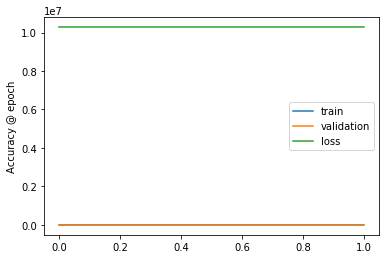

In [9]:
lr = 3e-4
epochs = 45
decoder_optimizer = torch.optim.Adam(rnn_decoder.parameters(), lr = lr)
encoder_optimizer = torch.optim.Adam(rnn_encoder.parameters(), lr = lr)
from chamfer_distance_loss import MyChamferDistance
loss = MyChamferDistance()

loss_history, train_history, val_history = train_model(
    encoder = rnn_encoder, 
    decoder = rnn_decoder, 
    train_loader = train_loader,
    val_loader = val_loader,
    loss = loss,
    decoder_opt = decoder_optimizer,
    encoder_opt = encoder_optimizer,
    epochs = epochs)

plot_history(loss_history, train_history, val_history)

In [13]:
from train import calculate_accuracy
i = 0
for (x, y) in iter(val_loader):
    outs, learned = rnn_encoder(x)
    decoded = rnn_decoder(outs, learned)
    
    yyy = []
    for yy in y:
        yyy.append(yy.shape[0])
    ppp = []
    for dd in decoded:
        ppp.append(dd.shape[0])
    
    print('yyy', yyy)
    print('prd', ppp)
    
    lv = loss(decoded, y)
    print ('loss', lv)

    acc = calculate_accuracy(decoded, y)
    print('acc', acc)

    i += 1
    print(i, '------------------------------')

yyy [100, 0]
prd [3609, 819]
loss tensor([79474.3594], grad_fn=<AddBackward0>)
acc [-4.821250915527344, 0]
1 ------------------------------
yyy [0, 0]
prd [1001, 687]
loss tensor([9.6915], grad_fn=<AddBackward0>)
acc [0, 0]
2 ------------------------------
yyy [3]
prd [1045]
loss tensor([1470.5341], grad_fn=<AddBackward0>)
acc [-10.246613502502441]
3 ------------------------------


In [15]:
ii = pd.DataFrame(x[0].cpu().detach().numpy())
print(ii.head())
yy = pd.DataFrame(y[0].cpu().detach().numpy())
print(len(yy))
print(yy.head())
pp = pd.DataFrame(decoded[0].cpu().detach().numpy())
print(len(pp))
print(pp.head())

     0    1    2    3    4    5           6           7    8
0  0.0  0.0  0.0  0.0  0.0  0.0  533.095825  568.467041  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0   24.872276   43.581280  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0   25.909851   18.372473  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0   25.909851   14.205807  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0   25.909851   30.523235  0.0
3
            0           1             2           3           4             5
0  177.459976  486.828461  4.050094e-15  178.803696  462.588440  4.050094e-15
1  184.617111  486.828461  0.000000e+00  184.617111  503.789246  1.115552e-14
2  265.694977  503.789246  1.115552e-14  249.887421  494.789246  2.536638e-14
1045
     0    1    2    3         4         5
0 -1.0 -1.0  1.0  1.0  0.996693  0.999892
1 -1.0 -1.0  1.0  1.0  0.996409  0.999946
2 -1.0 -1.0  1.0  1.0  0.996408  0.999946
3 -1.0 -1.0  1.0  1.0  0.996408  0.999946
4 -1.0 -1.0  1.0  1.0  0.996408  0.999946


In [16]:
from train import calculate_accuracy
torch.cuda.empty_cache()

rnn_encoder.eval()
rnn_decoder.eval()

test_accuracies = []
for (x,y) in test_loader:
    with torch.no_grad():
        out, hidden = rnn_encoder(x)
        prediction = rnn_decoder(out, hidden)
        accuracy = calculate_accuracy(prediction, y)
        test_accuracies.append(accuracy)
        
mean_test_accuracy = np.mean(test_accuracies)
print('Accuracy on testing: {0:2.3f}'.format(mean_test_accuracy))

TypeError: unsupported operand type(s) for /: 'list' and 'int'